In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
from glob import glob
from hydra import initialize, compose
from matplotlib import colors

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util

In [2]:
figure_dir = os.path.join(figure_dir, 'cartoon')
util.create_directory_if_not_exists(figure_dir)

In [3]:
lens = SampleStrongLens()

# unpickle and add subhalos
realization = util.unpickle(os.path.join(pickle_dir, 'cdm_subhalos_for_sample.pkl'))
lens.add_subhalos(realization)

# get source

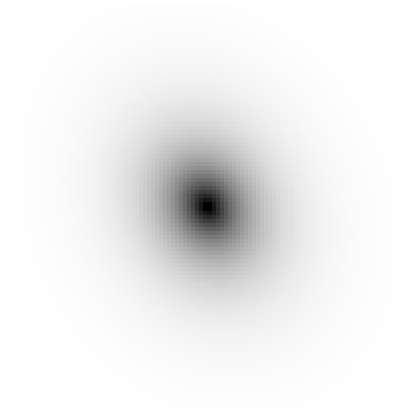

In [4]:
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF

kwargs_numerics = {'supersampling_factor': 1,  # each pixel gets super-sampled (in each axis direction)
                   'supersampling_convolution': False}

# set source image params
_ = lens.get_array(num_pix=100, side=1, band='F106')

# need to set up pixel grid - normally this is handled by a private method while getting the array
lens._set_up_pixel_grid()

# also need to update classes
lens._set_classes()

imageModel = ImageModel(data_class=lens.pixel_grid,
                        psf_class=PSF(**{'psf_type': 'NONE'}),
                        lens_model_class=None,
                        source_model_class=lens.source_model_class,
                        lens_light_model_class=None,
                        point_source_class=None,
                        kwargs_numerics=kwargs_numerics)

from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman

lenstronomy_roman_config = Roman(band='F106',
                                 psf_type='PIXEL',
                                 survey_mode='wide_area').kwargs_single_band()
magnitude_zero_point = lenstronomy_roman_config.get('magnitude_zero_point')

kwargs_lens_light_amp = lens._get_amp_light_kwargs(magnitude_zero_point, lens.lens_light_model_class,
                                                   lens.kwargs_lens_light_dict['F106'])
kwargs_source_amp = lens._get_amp_light_kwargs(magnitude_zero_point, lens.source_model_class,
                                               lens.kwargs_source_dict['F106'])

lens.kwargs_lens_light_amp_dict['F106'] = kwargs_lens_light_amp[0]
lens.kwargs_source_amp_dict['F106'] = kwargs_source_amp[0]

from copy import deepcopy

kwargs_source_copy = deepcopy(kwargs_source_amp)
kwargs_source_copy[0]['center_x'] = 0
kwargs_source_copy[0]['center_y'] = 0

image = imageModel.image(kwargs_lens=None,
                         kwargs_source=kwargs_source_copy,
                         kwargs_lens_light=None,
                         kwargs_ps=None)

plt.imshow(plot_util.asinh(image), cmap='binary')
plt.axis('off')
plt.savefig(os.path.join(figure_dir, 'source.png'), transparent=True)

# get lensed image

In [5]:
lensed_image = lens.get_array(num_pix=200, side=5., band='F106')

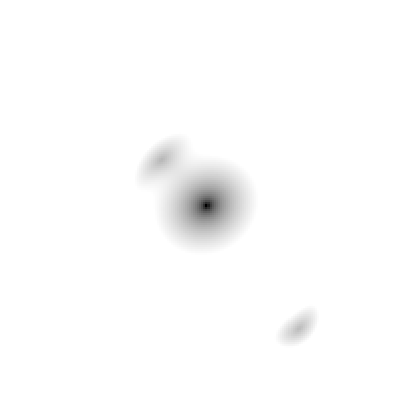

In [6]:
from copy import deepcopy

copy = deepcopy(lensed_image)
copy[copy < 0.25] = 0
plt.imshow(np.log10(copy), cmap='binary')
plt.axis('off')
plt.savefig(os.path.join(figure_dir, 'image.png'), transparent=True)

# get subhalos

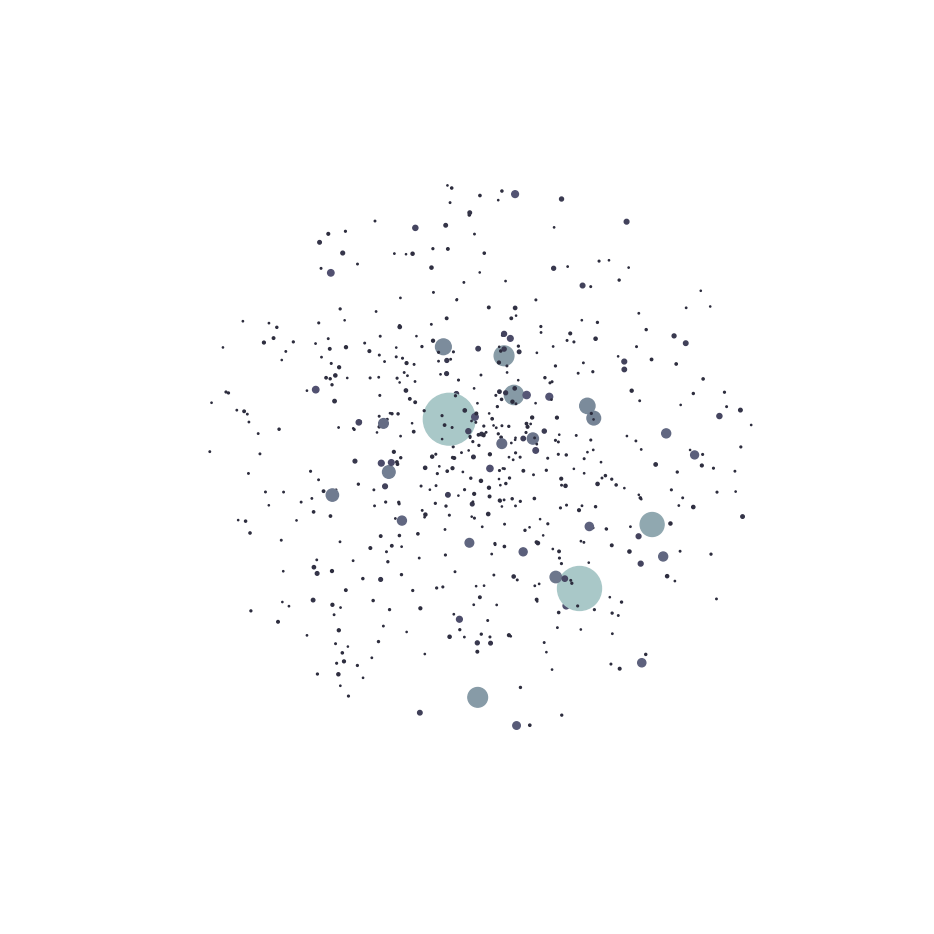

In [8]:
fig = plt.figure(2)
fig.set_size_inches(14, 12)
ax = plt.subplot(111, projection='3d')
realization.plot(ax, view_init_1=0., view_init_2=0)  # -30.
ax.set_axis_off()
ax.set_aspect('equalyz')
plt.savefig(os.path.join(figure_dir, 'subhalo_3d.png'), transparent=True)